In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt

In [20]:
n_samples = 1000

def get_dataset_1():
    centers = [(-5, -5), (0, 0), (5, 5), (-5, 5), (5, -5), (0, 5), (5, 0), (-5, 0), (0, -5)]
#     centers = [(-5, -5), (0, 0), (5, 5)]
    # centers = [(-5, -5), (5, -5), (5, 5)]
    X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False,
                  random_state=42)
    X = (X - X.mean())/X.std()
    return X, y

In [21]:
X, y = get_dataset_1()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Text(0.5, 1.0, 'Data')

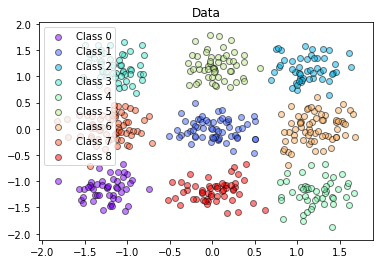

In [23]:
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

In [24]:
print(y_unique)

[0 1 2 3 4 5 6 7 8]


In [25]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
def get_model(initial_weights=None, input_dim=2, compile_model_flag=True, lr=0.001, activation='tanh', kernel_initializer=initializers.glorot_uniform(), 
              reduce = 1,  output_size = 3):
    # Creo el modelo
    inp = Input(shape=(input_dim,))
    #bias_initializer = initializers.RandomUniform(-0.1, 0.1)
    bias_initializer = initializers.glorot_uniform()
    #bias_initializer = initializers.zeros()
    first_layer_out = Dense(784//reduce, activation=activation, name='hidden_1', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, input_shape=(input_dim,))(inp)
    second_layer_out = Dense(784//reduce, activation=activation, name='hidden_2', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(first_layer_out)
    output = Dense(output_size, name='Salida', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, activation='softmax')(second_layer_out)
    model = Model(inp, output)
    model_multiple_out = Model(inp, [first_layer_out, second_layer_out, output])
    if compile_model_flag:
        compile_model(model, lr=lr)
    if initial_weights is not None:
        model.save_weights(initial_weights)
    return model, model_multiple_out

model, model_multiple_out = get_model(input_dim=2, output_size=len(y_unique))
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 784)               2352      
_________________________________________________________________
hidden_2 (Dense)             (None, 784)               615440    
_________________________________________________________________
Salida (Dense)               (None, 9)                 7065      
Total params: 624,857
Trainable params: 624,857
Non-trainable params: 0
_________________________________________________________________


In [27]:
initial_weights = 'mlp.blobs.initial.hdf5'
best_weights = 'mlp.blobs.best.hdf5'
model, model_multiple_out = get_model(input_dim=2, output_size=len(y_unique))
model.save_weights(initial_weights)
epochs = 5
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[
    ModelCheckpoint(filepath=best_weights,  verbose=0, save_best_only=True, monitor='val_loss', mode='auto')
])
model.load_weights(best_weights)

Epoch 1/5
16/16 [==============================] - 0s 12ms/step - loss: 0.9799 - accuracy: 0.6980 - val_loss: 0.3543 - val_accuracy: 0.9700
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.2547 - accuracy: 0.9740 - val_loss: 0.1494 - val_accuracy: 0.9800
Epoch 3/5
16/16 [==============================] - 0s 11ms/step - loss: 0.1257 - accuracy: 0.9780 - val_loss: 0.0992 - val_accuracy: 0.9800
Epoch 4/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0872 - accuracy: 0.9840 - val_loss: 0.1015 - val_accuracy: 0.9720
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 0.0747 - accuracy: 0.9820 - val_loss: 0.0820 - val_accuracy: 0.9760


In [28]:
from LTH_helper import plot_binary_multiclass_model

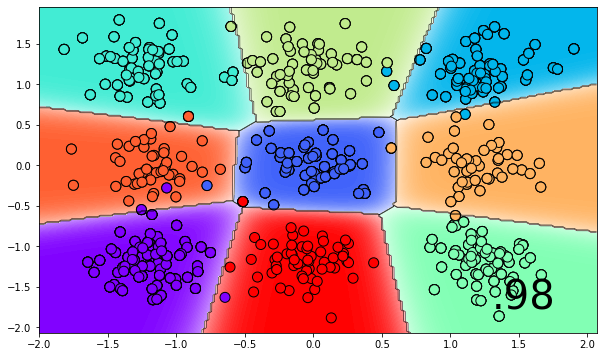

In [32]:
plt.figure(figsize=(10, 6))
plot_binary_multiclass_model(model, X_test, y_test)

In [81]:
from LTH_helper import prune_and_initilize, plot_MC_boundaries_keras, prune_delta_weights, get_model_sparcity

In [34]:
pms = np.linspace(0.0001, 0.9999, 50)
accs = []
model.load_weights(best_weights)
for i, pm in enumerate(pms):
    pruned_model = prune_and_initilize(model, pm, initial_weights)
    acc = pruned_model.evaluate(X_test, y_test, verbose=0)[1]
    accs.append(acc)
    print(i, pm, acc)

Instructions for updating:
Please use `layer.add_weight` method instead.
0 0.0001 0.09000000357627869
1 0.020504081632653062 0.09000000357627869
2 0.04090816326530613 0.09000000357627869
3 0.061312244897959195 0.18000000715255737
4 0.08171632653061225 0.2460000067949295
5 0.10212040816326531 0.33000001311302185
6 0.12252448979591839 0.3659999966621399
7 0.14292857142857143 0.37400001287460327
8 0.1633326530612245 0.3479999899864197
9 0.18373673469387755 0.3799999952316284
10 0.2041408163265306 0.4099999964237213
11 0.22454489795918367 0.47200000286102295
12 0.24494897959183676 0.5139999985694885
13 0.2653530612244898 0.5759999752044678
14 0.2857571428571429 0.6140000224113464
15 0.30616122448979594 0.6399999856948853
16 0.326565306122449 0.6859999895095825
17 0.34696938775510205 0.699999988079071
18 0.3673734693877551 0.7200000286102295
19 0.3877775510204082 0.7360000014305115
20 0.40818163265306123 0.7400000095367432
21 0.4285857142857143 0.7599999904632568
22 0.44898979591836735 0.76

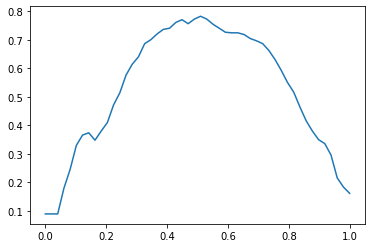

In [35]:
plt.plot(pms, accs)

In [36]:
model.load_weights(initial_weights)
model.evaluate(X_test, y_test, verbose=0)[1]

0.1599999964237213

0.5102020408163266 0.7820000052452087
16/16 [==============================] - 0s 927us/step - loss: 0.7626 - accuracy: 0.7820
0.7820000052452087


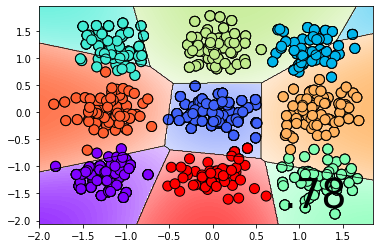

In [38]:
best = np.argmax(accs)
print(pms[best], accs[best])
model.load_weights(best_weights)
pruned_model = prune_and_initilize(model, pms[best], initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=0.99)

16/16 [==============================] - 0s 818us/step - loss: 1.4406 - accuracy: 0.4120
0.41200000047683716


/home/usuario/repos/prunning-fashion-MNIST/LTH_helper.py:277: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z_selected, (thres,), colors='k', linewidths=0.5)


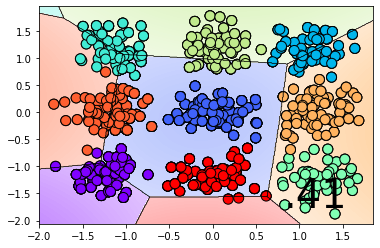

In [39]:
pruned_model = prune_and_initilize(model, 0.2, initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=0.99)

16/16 [==============================] - 0s 886us/step - loss: 1.1737 - accuracy: 0.5500
0.550000011920929


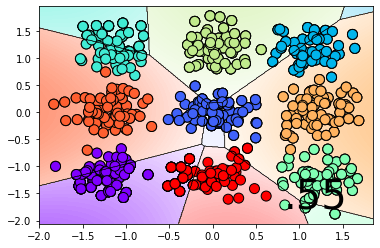

In [40]:
pruned_model = prune_and_initilize(model, 0.8, initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=1-1/9)

# Delta weights

In [41]:
initial_weights = 'mlp.blobs.initial.hdf5'
best_weights = 'mlp.blobs.best.hdf5'

In [42]:
# get_model_sparcity(model_delta)

In [64]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 818us/step - loss: 0.4912 - accuracy: 0.8360


[0.4911801517009735, 0.8360000252723694]

In [75]:
model, _ = get_model(input_dim=2, output_size=len(y_unique))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])
model_delta_untrained, model_delta_trained, model_untrained = prune_delta_weights(model, X_train, y_train, epochs=1)

model_delta_untrained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])
model_untrained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])
model_delta_trained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])

16/16 [==============================] - 0s 980us/step - loss: 1.0424 - accuracy: 0.6160


Text(0.5, 1.0, 'One Epoch Training')

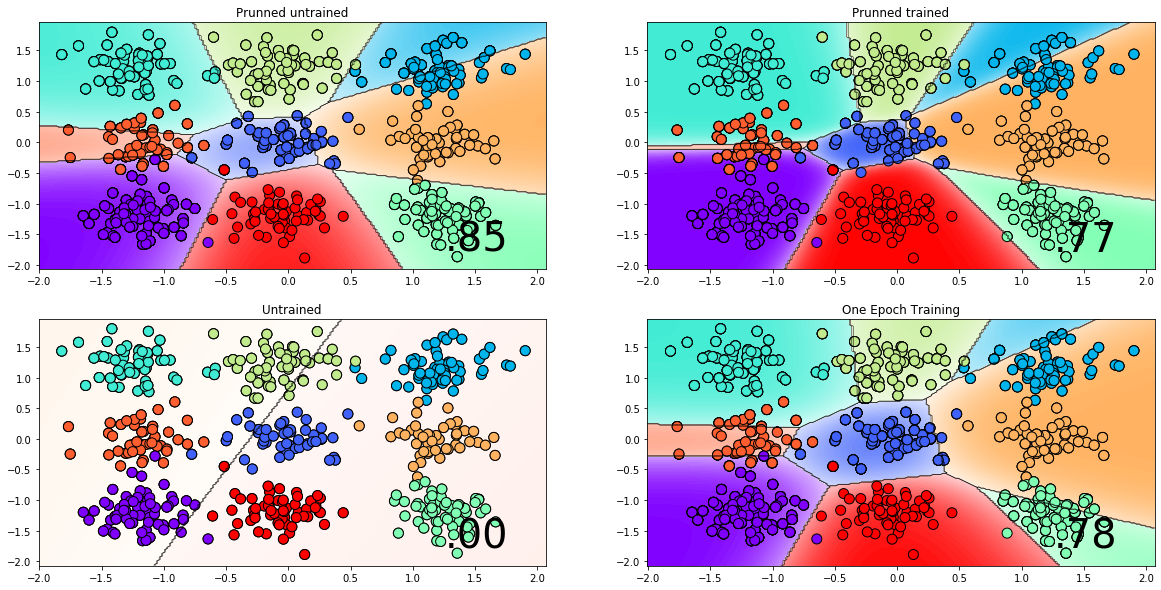

In [78]:
f, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.reshape(-1)
axs[0].set_title('Prunned untrained')
plot_binary_multiclass_model(model_delta_untrained, X_test, y_test, ax=axs[0])
axs[1].set_title('Prunned trained')
plot_binary_multiclass_model(model_delta_trained, X_test, y_test, ax=axs[1])
axs[2].set_title('Untrained')
plot_binary_multiclass_model(model_untrained, X_test, y_test, ax=axs[2])
axs[3].set_title('Trained')
plot_binary_multiclass_model(model, X_test, y_test, ax=axs[3])

In [85]:
model_untrained.save_weights('untrained.hdf5')
pruned_model_48 = prune_and_initilize(model, 0.48, 'untrained.hdf5')

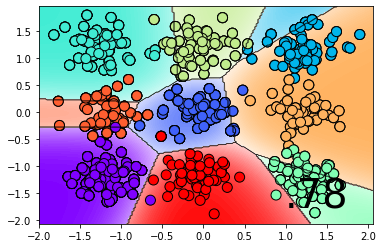

In [89]:
plt.figure()
plot_binary_multiclass_model(model, X_test, y_test)

In [91]:
get_model_sparcity(pruned_model_48)

prune_low_magnitude_hidden_1: 
0.5197704081632653 1568
0.0 784

prune_low_magnitude_hidden_2: 
0.5199981778425656 614656
0.0 784

prune_low_magnitude_Salida: 
0.5199829931972789 7056
0.0 9

Network sparcity:
0.5186850751451932


In [82]:
get_model_sparcity(model_delta_untrained)

input_77: 

hidden_1: 
0.26658163265306123 1568
0.41836734693877553 784

hidden_2: 
0.48743199448146607 614656
0.41964285714285715 784

Salida: 
0.3901643990929705 7056
0.5555555555555556 9

Network sparcity:
0.4856087072722239


In [83]:
get_model_sparcity(model_delta_trained)

input_77: 

hidden_1: 
0.26658163265306123 1568
0.41836734693877553 784

hidden_2: 
0.48743199448146607 614656
0.41964285714285715 784

Salida: 
0.3901643990929705 7056
0.5555555555555556 9

Network sparcity:
0.4856087072722239
